<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/14_Convolutions%20Deep%20Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 4.2 MB/s 
     |████████████████████████████████| 1.3 MB 48.4 MB/s 
     |████████████████████████████████| 365 kB 19.2 MB/s 
     |████████████████████████████████| 4.9 MB 25.2 MB/s 
     |████████████████████████████████| 115 kB 47.6 MB/s 
     |████████████████████████████████| 212 kB 18.2 MB/s 
     |████████████████████████████████| 120 kB 48.8 MB/s 
     |████████████████████████████████| 127 kB 49.1 MB/s 
     |████████████████████████████████| 6.6 MB 12.8 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Kernels and Convolutions

In this notebook we will dig into what convolutions are and building a CNN from scratch. We will then study a range of techniques to improve training stability and learn all the tweaks the library usually applies for us to get great results

One of the first features that image models try to get is edges on an image. It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use something called a convolution. A convolution requires nothing more than multiplication, and addition—two operations that are responsible for the vast majority of work that we will see in every single deep learning model. A convolution applies a kernel (little matrix) across an image. 

In [3]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
Path.BASE_PATH = path

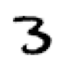

In [6]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [7]:
im3_t = tensor(im3)

Let's create a function to apply the top edge kernel over a part of the image and sum the results of it

In [8]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [9]:
#hide_output
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


We can see that the resulting tensor after applying the kernel will provide a high value for 5,7 but a small onefor 9,8.

In [10]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [11]:
apply_kernel(9,8,top_edge)

tensor(-25.)

We can apply the kernel over the whole image and visualize the output, where the horizontal edges are remarked:

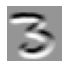

In [12]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

## Convolutions in Pytorch

Convolution is such an important and widely used operation that PyTorch has it built in. It's called F.conv2d (recall that F is a fastai import from torch.nn.functional, as recommended by PyTorch). The PyTorch docs tell us that it includes these parameters:


*   input:: input tensor of shape (minibatch, in_channels, iH, iW)
*   weight:: filters of shape (out_channels, in_channels, kH, kW)


Here iH,iW is the height and width of the image (i.e., 28,28), and kH,kW is the height and width of our kernel (3,3). But apparently PyTorch is expecting rank-4 tensors for both these arguments, whereas currently we only have rank-2 tensors (i.e., matrices, or arrays with two axes).

The reason for these extra axes is that PyTorch has a few tricks up its sleeve. The first trick is that PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

The second trick is that PyTorch can apply multiple kernels at the same time. So let's create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

In [13]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [14]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

One batch contains 64 images, each of 1 channel, with 28×28 pixels. F.conv2d can handle multichannel (i.e., color) images too. A channel is a single basic color in an image—for regular full-color images there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with dimensions [channels, rows, columns].

We'll see how to handle more than one channel later in this chapter. Kernels passed to F.conv2d need to be rank-4 tensors: [channels_in, features_out, rows, columns]. edge_kernels is currently missing one of these. We need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a unit axis) in the first location, where the PyTorch docs show in_channels is expected. To insert a unit axis into a tensor, we use the unsqueeze method:

In [15]:
edge_kernels = edge_kernels.unsqueeze(1)

In [16]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [17]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side). We can see we get the same results as when we did this manually:

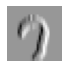

In [18]:
show_image(batch_features[0,0]);

It would be nice to not lose those two pixels on each axis. The way we do that is to add padding, which is simply additional pixels added around the outside of our image. Most commonly, pixels of zeros are added.

## Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image, which can make things a lot simpler when we construct our architecture. For example, 2ith a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

So far, when we have applied the kernel to the grid, we have moved it one pixel over at a time. But we can jump further; for instance, we could move over two pixels after each kernel application. This is known as a stride-2 convolution. The most common kernel size in practice is 3×3, and the most common padding is 1. As you'll see, stride-2 convolutions are useful for decreasing the size of our outputs, and stride-1 convolutions are useful for adding layers without changing the output size.

In an image of size h by w, using a padding of 1 and a stride of 2 will give us a result of size (h+1)//2 by (w+1)//2. The general formula for each dimension is:

*   (n + 2*pad - ks)//stride + 1
   

Where pad is the padding, ks, the size of our kernel, and stride is the stride.

In [19]:
(28+2*1-3)/(2+1) #for a 28x28 input with padding of 1, 3x3 kernel size and stride 2 we will go down to 9x9 output

9.0

## Our First Convolutional Neural Network

There is no reason to believe that some particular edge filters are the most useful kernels for image recognition. Furthermore, we've seen that in later layers convolutional kernels become complex transformations of features from lower levels, but we don't have a good idea of how to manually construct these.

Instead, it would be best to learn the values of the kernels. We already know how to do this—SGD! In effect, the model will learn the features that are useful for classification.

When we use convolutions instead of (or in addition to) regular linear layers we create a convolutional neural network (CNN).

Let's start with a simple model

In [20]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [21]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

We now want to create a similar architecture to this linear model, but using convolutional layers instead of linear. nn.Conv2d is the module equivalent of F.conv2d. It's more convenient than F.conv2d when creating an architecture, because it creates the weight matrix for us automatically when we instantiate it.

Here's a possible architecture:

In [22]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [23]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

This is not something we can use to do classification, since we need a single output activation per image, not a 28×28 map of activations. One way to deal with this is to use enough stride-2 convolutions such that the final layer is size 1. That is, after one stride-2 convolution the size will be 14×14, after two it will be 7×7, then 4×4, 2×2, and finally size 1.

In [24]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

When we use a stride-2 convolution, we often increase the number of features at the same time. This is because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time.

In [25]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [26]:
simple_cnn(xb).shape

torch.Size([64, 2])

With that shape, now we can create our learner

In [27]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [28]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

Note that the output of the final Conv2d layer is 64x2x1x1. We need to remove those extra 1x1 axes; that's what Flatten does. It's basically the same as PyTorch's squeeze method, but as a module.

In [29]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.061484,0.047412,0.984789,00:30
1,0.026977,0.030121,0.990186,00:17


## Understanding Convolution Arithmetic

We can see from the summary that we have an input of size 64x1x28x28. The axes are batch,channel,height,width. This is often represented as NCHW (where N refers to batch size).The first layer is:

In [30]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

So we have 1 input channel, 4 output channels, and a 3×3 kernel. Let's check the weights of the first convolution:

In [31]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

The summary shows we have 40 parameters, and 4*1*3*3 is 36. What are the other four parameters? Let's see what the bias contains:

In [32]:
m[0].bias.shape

torch.Size([4])

We can now use this information to clarify our statement in the previous section: "When we use a stride-2 convolution, we often increase the number of features because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time."

There is one bias for each channel. (Sometimes channels are called features or filters when they are not input channels.) The output shape is 64x4x14x14, and this will therefore become the input shape to the next layer. The next layer, according to summary, has 296 parameters. Let's ignore the batch axis to keep things simple. So for each of 14*14=196 locations we are multiplying 296-8=288 weights (ignoring the bias for simplicity), so that's 196*288=56_448 multiplications at this layer. The next layer will have 7*7*(1168-16)=56_448 multiplications.

What happened here is that our stride-2 convolution halved the grid size from 14x14 to 7x7, and we doubled the number of filters from 8 to 16, resulting in no overall change in the amount of computation. If we left the number of channels the same in each stride-2 layer, the amount of computation being done in the net would get less and less as it gets deeper. But we know that the deeper layers have to compute semantically rich features (such as eyes or fur), so we wouldn't expect that doing less computation would make sense.

Another way to think of this is based on receptive fields.

## Receptive Field

The receptive field is the area of an image that is involved in the calculation of a layer. The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer. A large receptive field means that a large amount of the input image is used to calculate each activation in that layer is. We now know that in the deeper layers of the network we have semantically rich features, corresponding to larger receptive fields. Therefore, we'd expect that we'd need more weights for each of our features to handle this increasing complexity. This is another way of saying the same thing we mentioned in the previous section: when we introduce a stride-2 conv in our network, we should also increase the number of channels.

## Color Images

A colour picture is a rank-3 tensor:

In [33]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

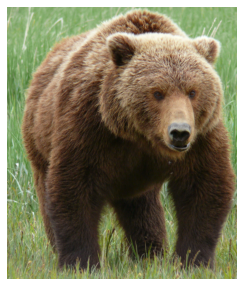

In [34]:
show_image(im);

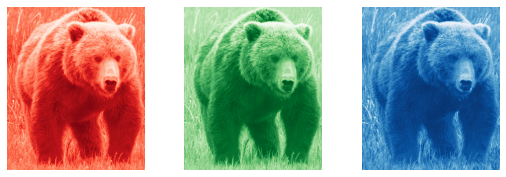

In [35]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

In one sliding window, we have a certain number of channels and we need as many filters (we don't use the same kernel for all the channels). So our kernel doesn't have a size of 3 by 3, but ch_in (for channels in) is 3 by 3. On each channel, we multiply the elements of our window by the elements of the coresponding filter, then sum the results (as we saw before) and sum over all the filters.

So, in order to apply a convolution to a color picture we require a kernel tensor with a size that matches the first axis. At each location, the corresponding parts of the kernel and the image patch are multiplied together.

These are then all added together, to produce a single number, for each grid location, for each output feature.

Then we have ch_out filters like this, so in the end, the result of our convolutional layer will be a batch of images with ch_out channels and a height and width given by the formula outlined earlier. This give us ch_out tensors of size ch_in x ks x ks that we represent in one big tensor of four dimensions. In PyTorch, the order of the dimensions for those weights is ch_out x ch_in x ks x ks.

Additionally, we may want to have a bias for each filter. In the preceding example, the final result for our convolutional layer would be *yr + yg + yb + b* in that case. Like in a linear layer, there are as many bias as we have kernels, so the biases is a vector of size ch_out.

There are no special mechanisms required when setting up a CNN for training with color images. Just make sure your first layer has three inputs.

# Improving Training Stability

We will focus now on classifying 10 different digits

In [36]:
path = untar_data(URLs.MNIST)

In [37]:
#hide
Path.BASE_PATH = path

In [38]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [39]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

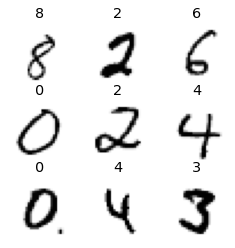

In [40]:
dls.show_batch(max_n=9, figsize=(4,4))

# A Simple Baseline

This is the first convolutional model we trained

In [41]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Let's start with a basic CNN as a baseline. We'll use the same one as earlier, but with one tweak: we'll use more activations. Since we have more numbers to differentiate, it's likely we will need to learn more filters.

As we discussed, we generally want to double the number of filters each time we have a stride-2 layer. One way to increase the number of filters throughout our network is to double the number of activations in the first layer–then every layer after that will end up twice as big as in the previous version as well.

But there is a subtle problem with this. Consider the kernel that is being applied to each pixel. By default, we use a 3×3-pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four output filters. That meant that there were four values being computed from nine pixels at each location. Think about what happens if we double this output to eight filters. Then when we apply our kernel we will be using nine pixels to calculate eight numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, if the number of outputs from an operation is significantly smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [42]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

As you'll see in a moment, we can look inside our models while they're training in order to try to find ways to make them train better. To do this we use the ActivationStats callback, which records the mean, standard deviation, and histogram of activations of every trainable layer (as we've seen, callbacks are used to add behavior to the training loop

In [43]:
from fastai.callback.hook import *

In [44]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [45]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.559118,0.555653,0.852700,01:42


One handy feature of the callbacks passed to Learner is that they are made available automatically, with the same name as the callback class, except in snake_case. So, our ActivationStats callback can be accessed through activation_stats

ActivationStats includes some handy utilities for plotting the activations during training. plot_layer_stats(idx) plots the mean and standard deviation of the activations of layer number idx, along with the percentage of activations near zero. Here's the first layer's plot:

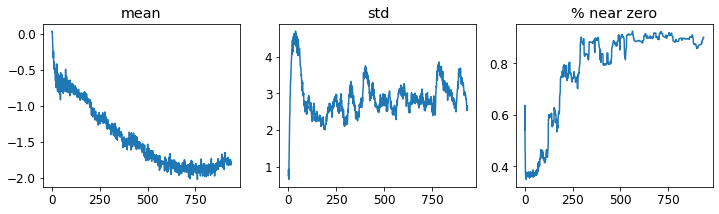

In [46]:
learn.activation_stats.plot_layer_stats(0)

Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

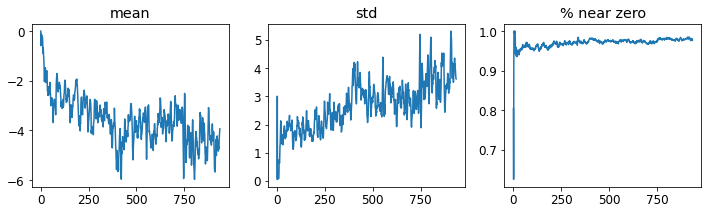

In [47]:
learn.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers. Let's look at what we can do to make training more stable.

# Increase Batch Size

One way to make training more stable is to increase the batch size. Larger batches have gradients that are more accurate, since they're calculated from more data. On the downside, though, a larger batch size means fewer batches per epoch, which means less opportunities for your model to update weights. Let's see if a batch size of 512 helps:

In [48]:
dls = get_dls(512)

In [49]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.307302,2.302386,0.113500,01:21


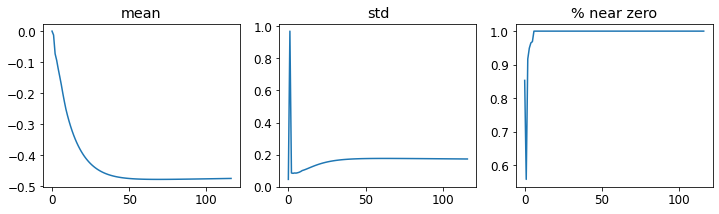

In [50]:
learn.activation_stats.plot_layer_stats(-2)

Next we will try adjusting the learning rate as increasing batch size does not solve the large number of zero activations

# First Cycle Training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we'll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

Leslie Smith developed this idea in his article "Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates". He designed a schedule for learning rate separated into two phases: one where the learning rate grows from the minimum value to the maximum value (warmup), and one where it decreases back to the minimum value (annealing). Smith called this combination of approaches 1cycle training.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:



*   By training with higher learning rates, we train faster phenomenon Smith named super-convergence. 
*   By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.


The second point is an interesting and subtle one; it is based on the observation that a model that generalizes well is one whose loss would not change very much if you changed the input by a small amount. If a model trains at a large learning rate for quite a while, and can find a good loss when doing so, it must have found an area that also generalizes well, because it is jumping around a lot from batch to batch (that is basically the definition of a high learning rate). The problem is that, as we have discussed, just jumping to a high learning rate is more likely to result in diverging losses, rather than seeing your losses improve. So we don't jump straight to a high learning rate. Instead, we start at a low learning rate, where our losses do not diverge, and we allow the optimizer to gradually find smoother and smoother areas of our parameters by gradually going to higher and higher learning rates.

Then, once we have found a nice smooth area for our parameters, we want to find the very best part of that area, which means we have to bring our learning rates down again. This is why 1cycle training has a gradual learning rate warmup, and a gradual learning rate cooldown. Many researchers have found that in practice this approach leads to more accurate models and trains more quickly. That is why it is the approach that is used by default for fine_tune in fastai.

We can also use momentum.Briefly, momentum is a technique where the optimizer takes a step not only in the direction of the gradients, but also that continues in the direction of previous steps. Leslie Smith introduced the idea of cyclical momentums in "A Disciplined Approach to Neural Network Hyper-Parameters". It suggests that the momentum varies in the opposite direction of the learning rate: when we are at high learning rates, we use less momentum, and we use more again in the annealing phase.

We can use 1cycle training in fastai by calling fit_one_cycle:

In [51]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [52]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.201400,0.074136,0.977800,01:25


We can view the learning rate and momentum throughout training by calling plot_sched on learn.recorder. learn.recorder (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum

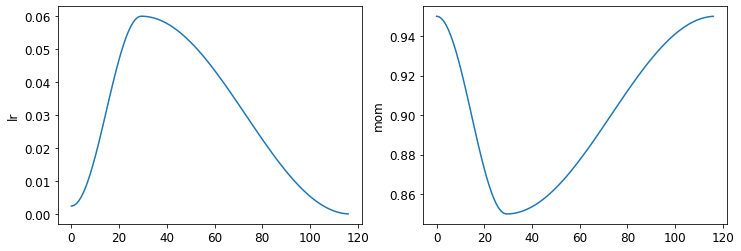

In [53]:
learn.recorder.plot_sched()

Smith's original 1cycle paper used a linear warmup and linear annealing. As you can see, we adapted the approach in fastai by combining it with another popular approach: cosine annealing.


Let's take a look at our layer stats again:

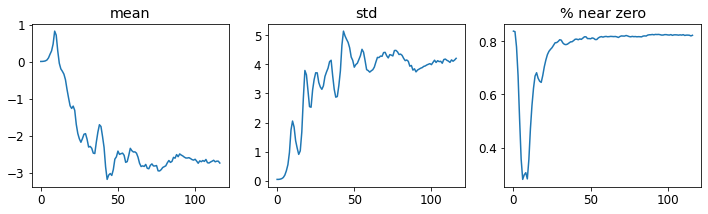

In [54]:
learn.activation_stats.plot_layer_stats(-2)

The percentage of near-zero weights is getting much better, although it's still quite high.

We can see even more about what's going on in our training using color_dim, passing it a layer index:

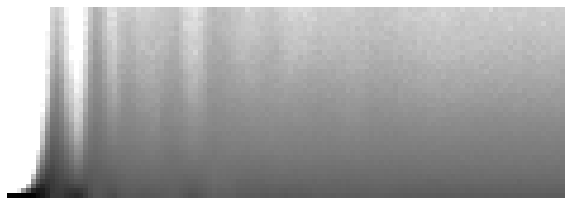

In [57]:
learn.activation_stats.color_dim(-2)

color_dim was developed by fast.ai in conjunction with a student, Stefano Giomo. Stefano, who refers to the idea as the colorful dimension, provides an in-depth explanation of the history and details behind the method. The basic idea is to create a histogram of the activations of a layer, which we would hope would follow a smooth pattern such as the normal distribution: 

***The final plot for each layer is made by stacking the histogram of the activations from each batch along the horizontal axis. So each vertical slice in the visualisation represents the histogram of activations for a single batch. The color intensity corresponds to the height of the histogram, in other words the number of activations in each histogram bin.***

This shows a classic picture of "bad training." We start with nearly all activations at zero—that's what we see at the far left, with all the dark blue. The bright yellow at the bottom represents the near-zero activations. Then, over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far, and collapses! We see the dark blue return, and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again, and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range.

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.